# STAT 201 Midterm 2 Review

In [18]:
#Load Pakages:
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)
library(broom)

## 1. Hypothesis Testing

###  1.1 Hypothesis Testing Steps (for a single sample case)
 1). Propose Null Hypothesis & Alternative Hypothesis & set up the significance level.  
 2). Collect a sample from the population and calculate the statistics needed for the test (test statistics).  
 3). Construct the sampling distribution using bootstrap.  
 4). Recenter the sampling distribution based on Null hypothesis to simulate the null model.  
 5). Calculate P-value using the null model & test statistics.  
 6). Compare P-value with the significance level:   
     &emsp;6.1). if P is smaller than the significance value, reject the null hypothesis (risk to commit type 1 error)  
     &emsp;6.2). if P is larger than the significance value, do not reject null hypothesis (risk to commit type 2 error)    
       
   **Note**: the probability to commit type 1 error equals to the p value   

### 1.2 Hypothesis Testing Workflow

In [4]:
# Using the dataset from WS 6
set.seed(7)
hcv_dataset <-
    read_csv("hcv-data-set.csv") %>% 
    mutate(category = fct_recode(category, "No-Fibrosis" = "Hepatitis")) %>% 
    filter(category != "Blood Donor") %>% 
    mutate(category = fct_drop(category))

Rows: 608 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): category, sex
dbl (11): age, albumin, alkaline_phosphatase, alanine_aminotransferase, 
asp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### 1.2A. Infer Package Workflow (single sample, one-tail test)

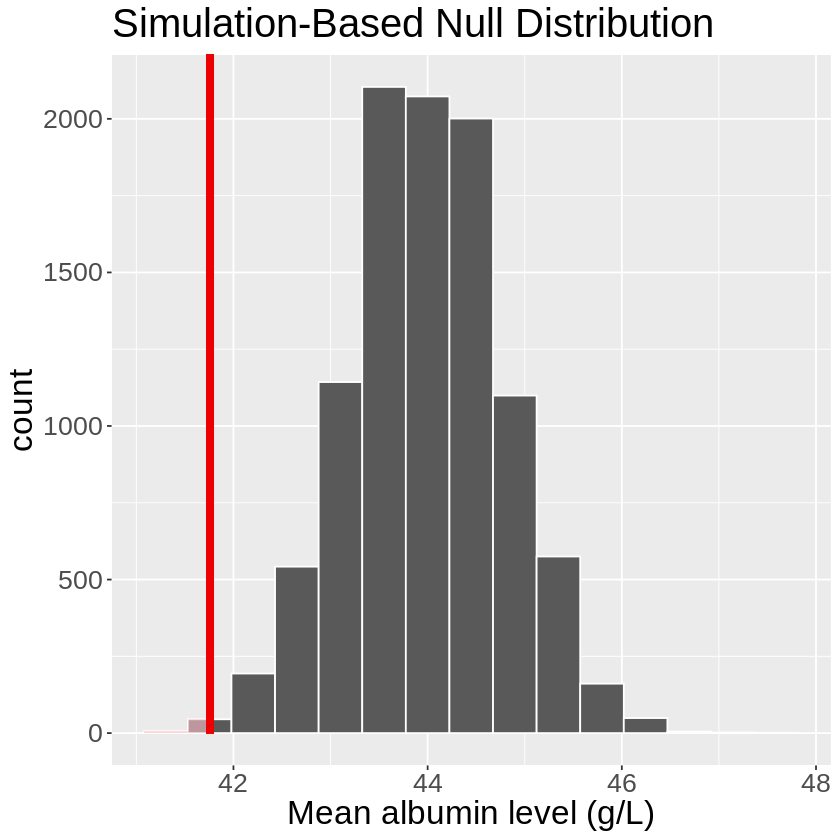

In [5]:
# Using the Example from WS 6: Null Hypothesis: mu = 44, Alternative Hypothesis: mu < 44
  # Step 1: Gather a sample, here we use the entire dataset as a sample:
    fibrosis <- hcv_dataset %>%                 
                filter(category == "Fibrosis") 
  # Step 2: Caculate the test statistics based on the sample
    obs_test_stat <- mean(fibrosis$albumin)
  # Step 3: Using Bootstraping to construct the bootstrap sampling distribution & Simulate the Null Model by recentering it at mu = 44
    null_model_infer <- fibrosis %>% 
                        specify(response = albumin) %>% 
                        hypothesise(null = "point", mu = 44) %>% #Using "point" here because we conduct hypothesis testing on a single sample
                        generate(type = "bootstrap", reps = 10000) %>% 
                        calculate("mean")
  # Step 5: Visualisation: Null Model & Test Statistics:
    null_model_vis_infer <- null_model_infer %>% 
                            visualize() + 
                            shade_p_value(obs_stat = obs_test_stat, direction = "left") +
                            xlab("Mean albumin level (g/L)") + 
                            theme(text = element_text(size=20))
  # Step 6: Calculate P-value:
    p_value_infer <- null_model_infer %>% 
                     get_p_value(obs_stat = obs_test_stat, direction = "left")
  # Step 7: Compare P-value with the Significance level to draw the conclusion
 null_model_vis_infer   

#### 1.2B. Hypothesis Testing using Tidyverse for visualization

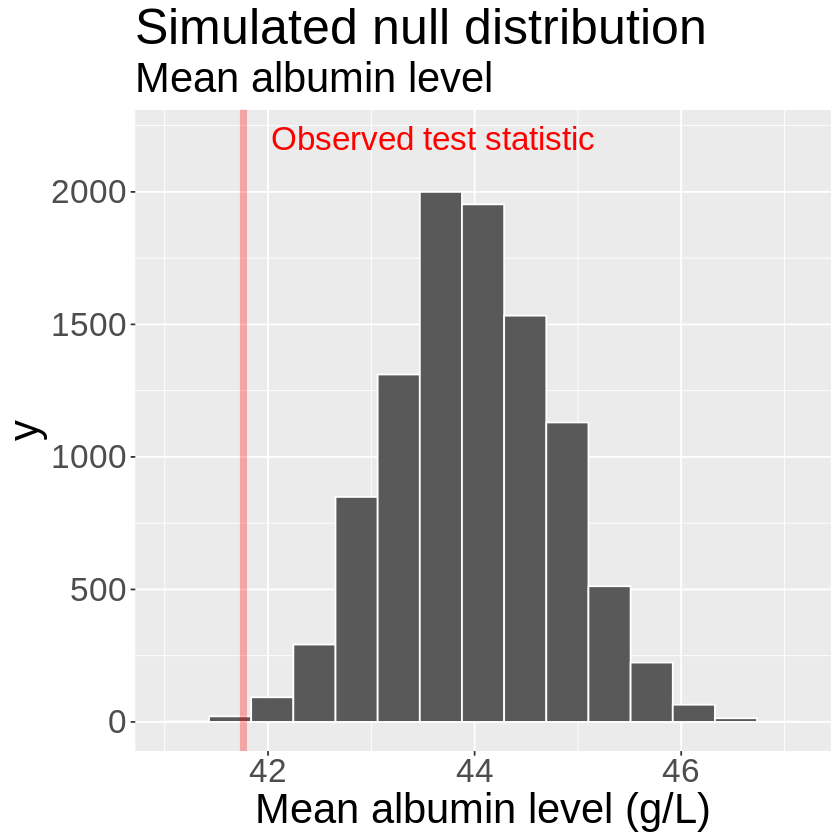

In [6]:
  # Step 1: Gather a sample, here we use the entire dataset as a sample: the same as above
  # Step 2: Caculate the test statistics: the same as above
  # Step 3: Use bootstrap to construct bootstrap samling distribution: the same or
    bootstrap_sampling <- fibrosis %>%
                          rep_sample_n(size = nrow(fibrosis), reps = 10000, replace = TRUE) %>%
                          group_by(replicate) %>%
                          summarize(mean = mean(albumin))
  # Step 4: Construct the null model by recentering the sampling distribution at mu = 44
    null_model <- bootstrap_sampling %>% 
                  mutate(stat = mean + (44 - obs_test_stat))
  # Step 5: Visualisation using ggplot:
    null_model_plot <- null_model %>% 
                       ggplot() +
                       geom_histogram(aes(x = stat), bins = 15, color="white") +
                       geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2) + 
                       xlab("Mean albumin level (g/L)") + 
                       theme(text = element_text(size=25)) + 
                       ggtitle("Simulated null distribution", subtitle = "Mean albumin level") +
                       annotate("text", x = 43.6, y = 2200, label = "Observed test statistic", color="red", size=7)
 # Step 6: Calculate P value:
   p_value <- mean(null_model$stat < obs_test_stat)
 # Step 7: Compare P-value with the Significance level to draw the conclusion
null_model_plot

#### 1.2C: Hypothesis Testing with 2 samples:

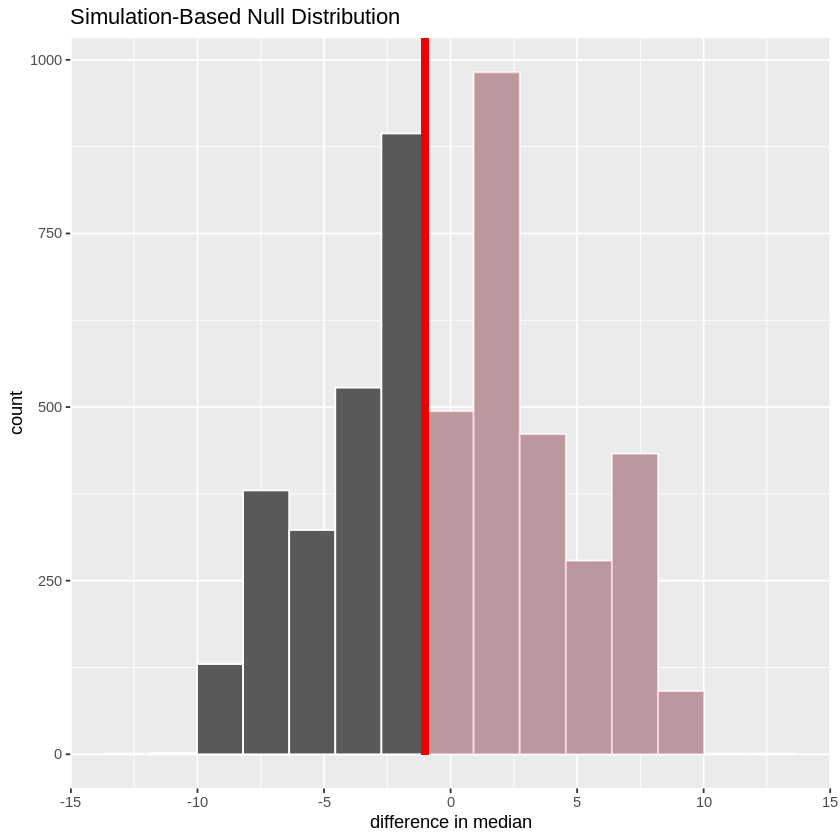

In [7]:
# Using examples from WS 6: Null Hypothesis: m1 - m2 = 0, Alternative Hypothesis: m1 - m2 >0
  # Step1 : Gather samples:
    trees_pop <- vancouver_trees %>% 
                 filter(neighbourhood_name %in% c("KITSILANO", "KERRISDALE")) %>% 
                 select(neighbourhood_name, diameter)
    sample_trees <- trees_pop %>% 
                    filter(neighbourhood_name=="KERRISDALE") %>% 
                    sample_n(size=35) %>% 
                    bind_rows(
                              trees_pop %>% 
                              filter(neighbourhood_name=="KITSILANO") %>% 
                              sample_n(size=31))
  # Step 2: Obtain the test statistics: m1 - m2
     obs_med_diam_diff <- - 1  
  # Step 3: Construct Null Model:
    null_model_trees <- sample_trees %>% 
                        specify(formula = diameter ~ neighbourhood_name) %>% 
                        hypothesise(null = "independence") %>%  # Use independence for 2 samples
                        generate(reps = 5000, type = "permute") %>% #use permute for 2 samples
                        calculate(stat="diff in medians", order = c("KITSILANO", "KERRISDALE"))
  # Step 4: Visualisation:
    trees_result_plot <- null_model_trees %>%
                         visualize() + 
                         shade_p_value(obs_stat = obs_med_diam_diff, direction = "right") +
                         xlab("difference in median")
  # Step 5: Obtain p value:
    p_value <- null_model_trees %>% 
               get_p_value(obs_stat = obs_med_diam_diff, direction = "right")
  # Step6: Draw the conclusion based on P value
trees_result_plot

### 1.3 Type 1 & Type 2 Error:  
**Type 1 Error**: reject null hypothesis when H0 is true (chance to commit equals to p value)  
**Type 2 Error**: accept a null hypothesis, when it is false.   
**Note**: when rejecting null hypothesis, we risk to commit type 1 error; when accept the null hypothesis, we risk to commit type 2 error.

### 1.4 Final Remark:
Increasing the sample size also increases the power the test because increasing the sample size makes the sampling distribution narrower, reducing the overlap between the true sampling distribution and the null model.

## 2. Confidence Interval & Central Limit Theorem

### 2.1 Statistical Ideas & Term Summary:

### 2.11 Five Number Summary & Outliers
1). **Minimum**  
2). **First Quantile (Q1)**: 25th Quantile: median of the first half of the sorted data.  
3). **Second Quantile (Q2)**: 50th Quantile: median  
4). **Third Quantile (Q3)**: 75th Quantile: median of the second half of the sorted data  
5). **Maximum**  
6). **Interquartile Range (IQR)**: Q3 – Q1: to see how spread out the middle 50% is  
7). **Outlier**:above Q3 + 1.5 IQR, below Q1 – 1.5 IQR

### 2.12 Normal Distribution: (mean: mu, sd: sigma)


**68%** lies within (mu - 1 sd, mu + 1sd)  
**95%** lies within (mu – 1.96 (2) sd, mu + 1.96 (2) sd)  
**99.7%** lies within (mu – 3 sd, mu + 3 sd)  
**Note**: mu controls the location of the curve while sigma controls the spread. As the sigma increases, the spread of the distribution increases


### 2.13 Central Limit Theorem (CLT)


When sample size is large enough, typically when n >= 30, the sampling distribution of the estimators (which should be sum of random components) becomes narrower and closer to a normal shape.   
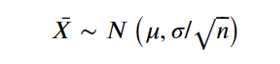  
**Note**: Central Limit Theorem does not assume the sample distribution; also, cannot conduct CLT when the sample size is larger than 10% of the population  
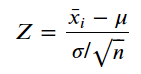  
**Use the formula above to calculate z score**


### 2.2 Central Limit Theorem Workflow on Obtaining CI

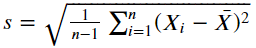  
**Note**: The equation above is for standard deviation; to calculate sigma, divide sd with sqrt(n) with n being the sample size  
**since we do not know mu or sigma, we use the sample estimates, namely sample mean and sample sd to estimate them**

In [8]:
## Load datasets from ws7:
penguins <- read.csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
body_mass_g_adelie <- penguins %>% 
                      filter(species == 'Adelie' & !is.na(body_mass_g)) %>% 
                      pull(body_mass_g)
## Step 1: Calculate Sample mean & Sample sd to estimate mu & sigma:
   n <- length(body_mass_g_adelie)
   mean <- mean(body_mass_g_adelie, na.rm = TRUE)
   std_error <- sd(body_mass_g_adelie, na.rm = TRUE) / sqrt(n)
## Step 2: Construct 95% confidence interval using mu and sigma:
    mean_body_mass_adelie_ci <-
     tibble(
         lower_ci = qnorm(0.025, mean = mean, sd = std_error),
         upper_ci = qnorm(0.975, mean = mean, sd = std_error)
     )
mean_body_mass_adelie_ci

lower_ci,upper_ci
<dbl>,<dbl>
3627.521,3773.803


### 2.3 Estimating Proportion Using CLT:

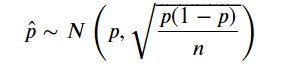  
**CLT is accurate in estimating proportions when** $n\hat{p}\geq 10$ and $n(1-\hat{p})\geq 10$, **thus, the larger the n is , the more accurate the CLT will be**

In [9]:
## Still use the penguin, estimate proportion of Adelie penguins with body_mass_g over 4000g
## Step 1: Calculate p & standard error using sample estimates:
          phat <- mean(body_mass_g_adelie > 4000)
          mean <- phat 
          std_error <- sqrt(phat * ( 1 - phat) / length(body_mass_g_adelie))
## Step 2: Construct the 95% Confidence Interval using values above
          prop_adelie_ci <- tibble(
                                    lower_ci = qnorm(0.05, mean = mean, sd = std_error),
                                    upper_ci = qnorm(0.95, mean = mean, sd = std_error)
                                    )
prop_adelie_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1753042,0.288272


### 2.4 Estimating the Difference in Means Using CLT

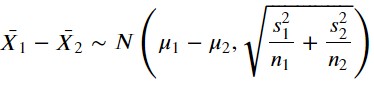  
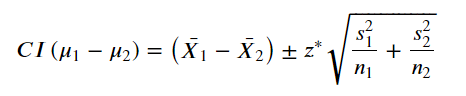  
**Note: Z here stands for the quantile of standard normal**

In [10]:
##  estimate the difference in the weights between the two species, Adelie and Chinstrap
## Gather the sample:
   adelie_chinstrap_sample <- penguins %>%
                              filter(species %in% c("Adelie", "Chinstrap") & !is.na(body_mass_g)) %>% 
                              select(species, body_mass_g)
   adelie <- adelie_chinstrap_sample %>% 
             filter(species == 'Adelie') %>% 
             pull(body_mass_g)

   chinstrap <- adelie_chinstrap_sample %>% 
                filter(species == 'Chinstrap') %>% 
                pull(body_mass_g)
## Use the CI equation above to calculate confidence interval:
   penguins_diff_means_ci <- 
     tibble(
         lower_ci = mean(adelie) - mean(chinstrap) - qnorm(0.975) * sqrt(var(adelie)/length(adelie) + var(chinstrap)/length(chinstrap)),
         upper_ci = mean(adelie) - mean(chinstrap) + qnorm(0.975) * sqrt(var(adelie)/length(adelie) + var(chinstrap)/length(chinstrap))
     )
penguins_diff_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-149.4484,84.59648


## 3. Classical Test Based on Normal and T distribution

### 3.1 Z-test vs T-test

**Z test**: Z test uses the normal distribution N(0,1) by rescaling the standard deviation & recenter the mu at 0.  
&emsp;**Note**: Z test is essentially applying the CLT so it assumes not about the population distribution & requires the sample to be larger enough (n>= 30) while smaller than 10% of the total population  
**T test**: T test uses T distribution (T(degree of freedom)) whose difference with the normal distribution is that it has heavier tails. T test assumes that the population distribution is approximately normal & does not require a large sample size. 
   

### 3.2 Z-test Workflow:

#### 3.2A One Sample Z Test with Proportion

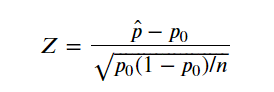  
**Note**: use this formula to calculate z score

In [20]:
## Use the example from WS 8:
## Load data:
# Run this cell before continuing.
contraceptive_survey_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data", 
                                       col_names = FALSE) %>% 
                             select(X2, X10) %>% 
                             mutate(X2 = as_factor(X2), X10 = as_factor(X10)) %>% 
                             rename(education_level = X2, contraceptive = X10) %>% 
                             mutate(education_level = fct_recode(education_level,
                                                                 "high" = "4",
                                                                 "high" = "3", 
                                                                 "low" = "2",
                                                                 "low" = "1"),
                                    contraceptive = fct_recode(contraceptive,
                                                              "No" = "1",
                                                              "Yes" = "2",
                                                              "Yes" = "3")) %>%
                             sample_n(10) %>% 
                             head()
## Null Hypothesis: p = 0.5, alternative Hypothesis: p > 0.5
## Step 1: Caculate z:
           phat <- mean(contraceptive_survey_data$contraceptive == "Yes")
           z <- (phat - 0.5) / sqrt( 0.5 * (1-0.5)/nrow(contraceptive_survey_data))
## Step 2: Caculate P value:
           pvalue <- pnorm(z, lower.tail = FALSE)
## Step 3: Draw Conclusion from the p value

## Alternative Approach:
       result <- tidy(prop.test(x = sum(contraceptive_survey_data$contraceptive == "Yes"), ## the number of successes
                 n = nrow(contraceptive_survey_data), 
                 p = 0.5,      # p from the null hypothesis
                 alternative = "greater", ## alternative hypothesis: "less", "greater", "two.sided", comparing with the null
                 conf.level = 0.85,
                 correct=FALSE))
result

Rows: 1473 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in prop.test(x = sum(contraceptive_survey_data$contraceptive == :
“Chi-squared approximation may be incorrect”


estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
0.5,0,0.5,1,0.3051623,1,1-sample proportions test without continuity correction,greater


#### 3.2B Two Sample Z Test:

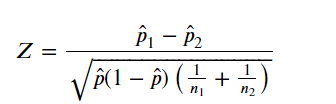  
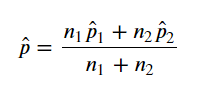

In [25]:
## Null Hypothesis: p1 = p0; alternative hypothesis: p1 is not equal to p0
###Step 1: Calculate Z:
        qnts <- contraceptive_survey_data %>% 
                group_by(education_level) %>% 
                count(contraceptive)  %>% 
                mutate(phat = n/sum(n))
          n1 <- qnts %>% 
                filter(education_level == "high") %>% 
                pull(n) %>% 
                sum()          
          n2 <- qnts %>% 
                filter(education_level == "low") %>% 
                pull(n) %>% 
                sum()          
          phat1 <- qnts %>% 
                   filter(education_level == "high" & contraceptive == "Yes") %>% 
                   pull(phat)         
          phat2 <- qnts %>% 
                   filter(education_level == "low" & contraceptive == "Yes") %>%
                   pull(phat)          
          phat <- (n1 * phat1 + n2*phat2)/(n1 + n2)          
          z <- (phat1 - phat2) / (sqrt(phat*(1-phat)*(1/n1 + 1/n2)))
### Step 2: Calculate P value: 2 tails:
            p <- 2 * pnorm(z, lower.tail = FALSE)
### Step 3: Draw Conclusion based on p
## Alternative Approach: 
   p <- tidy(prop.test(x = c(n1*phat1, n2*phat2), ## an array with the number of successes in each sample
                             n = c(n1, n2),             ## an array with the size of each sample
                             correct = FALSE))

ERROR: Error in prop.test(x = c(n1 * phat1, n2 * phat2), n = c(n1, n2), correct = FALSE): 'x' and 'n' must have the same length


### 3.3 T-Test Workflow:

#### 3.3A: One Sample T-test

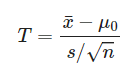

In [29]:
## Load data from ws8:
   body_temp <- read.table("http://jse.amstat.org/datasets/normtemp.dat.txt",
                            col.names = c("body_temp", "sex", "heart_rate"), header = FALSE) %>% 
                mutate(sex = if_else(sex == 1, "male", "female")) %>% 
                mutate(sex = as_factor(sex))
## Null Hypothesis: u1 = u0; alternative Hypothesis: u1 is not equal to u0:
## Step1 : Calculate Test Statistics:
           observed_test_statistic3.1.3 <- sqrt(nrow(body_temp)) * (mean(body_temp$body_temp) - 98.2) / sd(body_temp$body_temp)
## Step2 : Calculate p value:
           p <- 2 * pt(observed_test_statistic3.1.3, 
                       df = nrow(body_temp) - 1, # df = n -1 for 1 sample; df = 2n -2 for two samples
                       lower.tail = FALSE )
## Step3: Compare p with significance level to draw results

## Alternative Approach:
   p <- tidy( t.test(body_temp$body_temp, mu = 98.2) )

#### 3.3B: Two Sample T test: (independent samples)

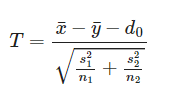  
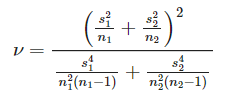  
**Note**: samples can be different sizes

In [33]:
## Load Data:
   adelie_chin <- penguins %>% 
                  filter(species %in% c("Adelie", "Chinstrap")) # Do not delete this
## Hypothesis Test: Null: u0 = u1, Alternative u0 not equal to u1 (two tail)
## Step 1: Calculate T values:
           adelie_chin_summary <- adelie_chin %>% 
                                  filter(!is.na(flipper_length_mm)) %>% 
                                  group_by(species) %>% 
                                  summarise(sample_mean = mean(flipper_length_mm), sample_var = var(flipper_length_mm), n = n())
           T <- (adelie_chin_summary$sample_mean[2] - adelie_chin_summary$sample_mean[1]) / 
                 sqrt(adelie_chin_summary$sample_var[2]/adelie_chin_summary$n[2] + adelie_chin_summary$sample_var[1]/adelie_chin_summary$n[1])
## Step3: Calculate p values:
          p <- 2 * pt(T, 120, lower.tail=FALSE)
## Step4: Compare p with significance level to draw conclusion:

##Alternative:
  p <- tidy( t.test(x = adelie_chin %>% filter(species == "Chinstrap") %>% pull(flipper_length_mm), 
                    y = adelie_chin %>% filter(species == "Adelie") %>% pull(flipper_length_mm),
                    alternative = "two.sided"))

#### 3.3C: Paired T-test: (dependent samples & means)

**Note**: samples must be of the same size

In [37]:
## Load data from ws 8:
   training_data <- read_csv("training_data")
                    head(training_data)
   training <- training_data %>% 
               mutate(d = after_training - before_training)
## Null Hypothesis: b = a; alternative: a > b
## Step 1: calculate T
           T <- sqrt(nrow(training))*mean(training$d)/sd(training$d)
## Step 2: Caculate P:
           p <- pt(T, nrow(training) - 1, lower.tail = FALSE)

Rows: 50 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): before_training, after_training

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


before_training,after_training
<dbl>,<dbl>
32.20819,69.65499
31.57785,39.63263
26.41378,48.02689
38.95192,40.93712
28.36233,26.11470
21.42910,24.52457
